# Classification

## 1. Data

The dataset for this lecture was prepared by the MoleculeNet group [WRF+18]. It is a collection of molecules that succeeded or failed in clinical trials.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import rdkit, rdkit.Chem, rdkit.Chem.Draw
import numpy as np
import jax.numpy as jnp
import mordred, mordred.descriptors
import jax

In [3]:
# from zipfile import ZipFile
# from io import BytesIO
# from urllib.request import urlopen

# from web version
# url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz'
# file = urlopen(url).read()
# file = BytesIO(file)
# document = ZipFile(file)
# toxdata = pd.read_csv(document.open('clintox.csv'))

# local version
toxdata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/clintox.csv.gz"
)
toxdata.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


## 2. Molecular Descriptors

This time, our data does not come with pre-computed descriptors. We only have the SMILES string, which is a way of writing a molecule using letters and numbers (a string). We can use rdkit to convert the SMILES string into a molecule, and then we can use a package called Mordred to compute a set of descriptors for each molecule. This package will compute around 1500 descriptors for each molecule.

We’ll start by converting our molecules into rdkit objects and building a calculator to compute the descriptors.

[12:27:35] Explicit valence for atom # 0 N, 5, is greater than permitted
[12:27:35] Can't kekulize mol.  Unkekulized atoms: 9
[12:27:35] Explicit valence for atom # 10 N, 4, is greater than permitted
[12:27:35] Explicit valence for atom # 10 N, 4, is greater than permitted
[12:27:35] Can't kekulize mol.  Unkekulized atoms: 4
[12:27:35] Can't kekulize mol.  Unkekulized atoms: 4


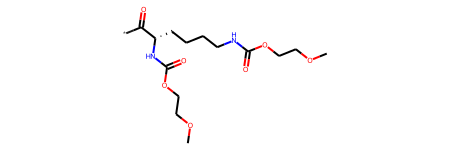

In [4]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# view one molecule to make sure things look good.
molecules[0]

Some of our molecules failed to be converted. We’ll have to remove them. We need to remember which ones were deleted too, since we need to remove the failed molecules from the labels.

In [5]:
# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]

# Get the features from the mordred calculator
features = calc.pandas(valid_mols)

/home/eloisanchez/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eloisanchez/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eloisanchez/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eloisanchez/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eloisanchez/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eloisanchez/.local/lib/python3.10/site-packa

Now we just need to stich everything back together so that our labels are consistent and standardize our features.

In [6]:
labels = toxdata[valid_mol_idx].FDA_APPROVED
features -= features.mean()
features /= features.std()

# we have some nans in features, likely because std was 0
features.dropna(inplace=True, axis=1)

print(f"We have {len(features.columns)} features per molecule")

/tmp/ipykernel_6531/2238410431.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features -= features.mean()


We have 483 features per molecule


## 3. Classification Models

### 3.1. Linear Perceptron

We can use regression. Basically if $\vec{w}·\vec{x}+b>0$ then $\hat{f}(\vec{x})=1$ and $\hat{f}(\vec{x})=0$ otherwise.

This model is called **perceptron** and is the first neuran network for classification. It is an example of a **hard** classifier, as it does not predict the probability of the class, it just predicts exactly one class.

The distance of $\vec{w}·\vec{x}+b$ from 0 is called the **decision boundary**.

In [7]:
def perceptron(x, w, b):
    v = jnp.dot(x, w) + b
    y = jnp.where(v > 0, x=jnp.zeros_like(v), y=jnp.ones_like(v))
    return y

Now that we have a model, we must choose a loss function. We haven’t learned about many loss functions yet. We’ve only seen mean squared error. Let us begin with a related loss called mean absolute error (MAE). MAE measures disagreement between our class and the predicted class. This is like an accuracy – what percentage of the time we’re correct.
$$
L=\frac{1}{N}\sum_i{|y_i-\hat{y}_i|}
$$

In [8]:
def loss(y, yhat):
    return jnp.mean(jnp.abs(y - yhat))


def loss_wrapper(w, b, x, y):
    yhat = perceptron(x, w, b)
    return loss(y, yhat)


loss_grad = jax.grad(loss_wrapper, (0, 1))

Now create the training and testing sets

In [9]:
batch_size = 32
train_N = int(len(labels) * 0.8)  # 80% for training and 20% for testing


N = len(labels)
batch_idx = range(0, train_N, batch_size)

# Random initialization of the parameters
w = np.random.normal(size=len(features.columns))
b = 0.0

# Create the function to calculate the gradient
loss_grad = jax.grad(loss_wrapper, (0, 1))

# Get the testing datasets
test_x = features[train_N:].values.astype(np.float32)
test_y = labels[train_N:].values

print(test_x.shape, test_y.shape)

(296, 483) (296,)


Let’s now try out our gradient to make sure it works

In [10]:
loss_grad(w, b, test_x, test_y)

(DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 

It’s all zeros! Why is that? It’s because our `jnp.where` statement above is not differentiable, nor are any inequalities where the result is a constant (1 or 0 in our case). The perceptron actually has a special training procedure that is not related to its derivatives. One of the motivating reasons that deep learning is popular is that we do not need to construct a special training process for each model we construct – like the training procedure for the perceptron.

### 3.2 Logistic Regression

Rather than teach and discuss the special perceptron training procedure, we’ll move to a more modern related classifier called a softmax binary classifier. This is a tiny change, the softmax binary classifier is:
$$
\hat{f}(\vec{x}) = \sigma(\vec{w}·\vec{x}+b)
$$

The input to the sigmoid can be viewed as log-odds, called logits for short. Odds are ratios of probability – odds of 1 means the probability of the class 1 is 0.5 and class 0 is 0.5. Odds of 2 means the probability of class 1 is 0.67 and class 0 is 0.33. Log-odds is the natural logarithm of that, so that log-odds of 0 means the odds are 1 and the output probability should be 0.5. One definition of the sigmoid is
$$
\sigma(x)=\frac{1}{1+e^{-x}}
$$

This type of binary classifier is sometimes called logistic regression because we’re regressing logits.

In essence, all we’ve done is replacing the inequality of the perceptron with a smooth differentiable version. Just like previously, a positive number indicated class 1 (FDA approved) but now it’s a continuum of numbers from 0.5 to 1.0. This is **soft** classification – we give probabilities of class membership instead of hard assignment. However, our loss function now needs to be modified as well.

There is a different loss function that works better with classification called **cross-entropy**. Cross-entropy is a loss function that describes distance between two probability distributions. When minimized, the two probability distributions are identical.

How is comparing predicted values $\hat{y}$ and $y$ like comparing two probability distributions? Even though these are both 1s and 0s in the case of hard classification, they do sum to 1, and so we consider them probability distributions. Cross-entropy is defined as:
$$
L=-\sum_c^K{y_c \log{\hat{y}_c}}
$$

Where $c$ indicates the class considered and it's assumed that $\sum_c^K y_c=1$ and $\sum_c^K \hat{y}_c=1$ like probabilities. When we have a binary classification $y_1 = 1 - y_0$ is also fulfilled and the loss function becomes
$$
L=-[y_0 \log{\hat{y}_0}+(1-y_0)\log{(1-\hat{y}_0})]
$$

Now we can create a batched gradient descent algorithm to train the classifier. Note, one change we need to do is use the built-in jax jax.nn.sigmoid function to avoid numerical instabilities and also add a small number to all logs to avoid numerical instabilities.

In [11]:
def bin_classifier(x, w, b):
    v = jnp.dot(x, w) + b
    return jax.nn.sigmoid(v)


def cross_ent(y, yhat):
    # Note that we add 1e-10 to the args of the logs to avoid numerical instability
    return jnp.mean(-(y * jnp.log(yhat + 1e-10) + (1 - y) * jnp.log(1 - yhat + 1e-10)))


def loss_wrapper(w, b, x, y):
    yhat = bin_classifier(x, w, b)
    return cross_ent(y, yhat)


loss_grad = jax.grad(loss_wrapper, (0, 1))

# Initialize random parameters
w = np.random.normal(scale=0.01, size=len(features.columns))
b = 1.0

# Check that the gradient function works
loss_grad(w, b, test_x, test_y)

(DeviceArray([ 0.01369678,  0.01290647, -0.04203382,  0.03414671,
               0.06463736,  0.06418101, -0.00312788,  0.00633956,
               0.05294057,  0.01003047, -0.02009723, -0.01178875,
               0.00788175,  0.0190418 ,  0.02130545, -0.03921411,
              -0.07326884, -0.01063615,  0.0381923 ,  0.03393472,
               0.04042657, -0.01971834,  0.04144726,  0.00363575,
               0.02625596,  0.01601606,  0.02002408,  0.00860181,
              -0.00419635, -0.00821917, -0.0115884 , -0.01803072,
               0.01465524,  0.01543103,  0.02008337,  0.01658573,
               0.01459567,  0.00932183,  0.00347562, -0.00243503,
              -0.00672388, -0.03428435, -0.02379368,  0.00139962,
               0.00356513, -0.01189856, -0.01151679, -0.01581604,
              -0.01738641, -0.02055702,  0.01193847,  0.08938903,
              -0.07757836, -0.0066368 ,  0.01536253, -0.04846675,
              -0.05601464,  0.02588408,  0.01924275, -0.019254  ,
          

Now we create the training loop

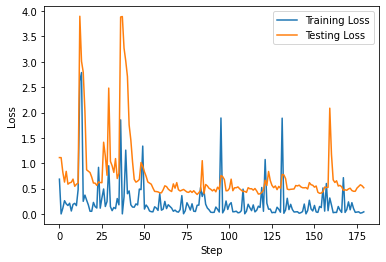

In [12]:
loss_progress = []
test_loss_progress = []
eta = 0.2
for epoch in range(5):
    for i in range(len(batch_idx) - 1):
        # 1. Get data of this batch
        x = features[batch_idx[i] : batch_idx[i + 1]].values.astype(np.float32)
        y = labels[batch_idx[i] : batch_idx[i + 1]].values
        # 2. Calculate gradient with this batch
        grad = loss_grad(w, b, x, y)
        # 3. Change the parameters in the direction of descending gradient
        w -= eta * grad[0]
        b -= eta * grad[1]
        # 4. Recalculate loss and save
        loss_progress.append(loss_wrapper(w, b, x, y))
        test_loss_progress.append(loss_wrapper(w, b, test_x, test_y))
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.legend()
plt.ylabel("Loss")
plt.show()

## 4. Classification Metrics

In regression, we assessed model performance with a parity plot, correlation coefficient, or mean squared error. In classification, we use slightly different metrics. The first metric is **accuracy**. Accuracy is the percentage of time that the predicted label matches the true label. We do not have a hard classifier, so we have to choose how to turn probability into a specific class. For now, we will choose the class with the highest probability. Let’s see how this looks

In [13]:
def accuracy(y, yhat):
    # Conver from prob to hard class
    #? Why do we use the ones_like function and not 1
    hard_yhat = np.where(yhat > 0.5, np.ones_like(yhat), np.zeros_like(yhat))
    disagree = np.sum(np.abs(y-hard_yhat))
    return 1 - disagree / len(y)

accuracy(test_y, bin_classifier(test_x, w, b))

0.8682432432432432

An accuracy of 0.83 seems quite reasonable! However, consider this model:

In [14]:
def alt_classifier(x):
    return np.ones((x.shape[0]))


accuracy(test_y, alt_classifier(test_x))

0.9087837837837838

This model, which always returns 1, has better accuracy than our model. How is this possible?

If you examine the data, you’ll see the majority of the molecules passed FDA clinical trials ($y=1$), so that just guessing 1 is a good strategy.

### 4.1. Error Types

Let’s recall what we’re trying to do. We’re trying to predict if a molecule will make it through FDA clinical trials. Our model can be incorrect in two ways: it predicts a molecule will pass through clinical trials, but it actually fails. This is called a **false positive**. The other error is if we predict our drug will not make it through clinical trials, but it actually does. This is **false negative**.

Our `alt_classifier` model, which simply reports everything as positive, has no false negative errors. It has many false positive errors. These two types of errors can be quantified. We’re going to add one complexity – threshold. Although we train our model to minimize cross-entropy, we may want to be more conservative or aggressive in our classification with the trained model.

In [15]:
def error_types(y, yhat, threshold):
    hard_yhat = np.where(yhat >= threshold, np.ones_like(yhat), np.zeros_like(yhat))
    # predicted 1, actually was 0 -> 1 (bool to remove predicted 0, actually was 1)
    fp = np.sum((hard_yhat - y) > 0)
    # predicted 0, actually was 1 -> 1 (bool to remove predicted 1, actually was 0)
    fn = np.sum((y - hard_yhat) > 0)
    return fp, fn

In [16]:
print("Alt Classifier", error_types(test_y, alt_classifier(test_x), 0.5))
print("Trained Classifier", error_types(test_y, bin_classifier(test_x, w, b), 0.5))

Alt Classifier (27, 0)
Trained Classifier (20, 19)


We can see how increasing the threshold will minimize false positives at the cost of missing more possible aprovable molecules

In [17]:
print("Threshold 0.7", error_types(test_y, bin_classifier(test_x, w, b), 0.7))
print("Threshold 0.9", error_types(test_y, bin_classifier(test_x, w, b), 0.9))
print("Threshold 0.95", error_types(test_y, bin_classifier(test_x, w, b), 0.95))
print("Threshold 0.99", error_types(test_y, bin_classifier(test_x, w, b), 0.99))

Threshold 0.7 (19, 27)
Threshold 0.9 (11, 74)
Threshold 0.95 (6, 124)
Threshold 0.99 (1, 220)


In the last case we didn't obtain any false positive but we missed 215 possible molecules. Are we still obtainging some true positive molecules though?

In [18]:
total_pos = np.sum(test_y)
print(
    "Total positives:",
    total_pos,
    "Predicted Positives:",
    np.sum(bin_classifier(test_x, w, b) > 0.99),
)

Total positives: 269 Predicted Positives: 50


Yes, we are obtaining 54 molecules that will pass the FDA test while minimizing the false possitives a lot. We cannot do that with `alt_classifier`, since it only provides ones.

### 4.2. Receiver-Operating Characteristic Curve

We can plot threshold, false positive rate, and true positive rate all together on one plot to capture model accuracy and balance between error type in a Receiver-Operating Characteristic Curve (**ROC curve**). The x-axis of ROC curve is false positive rate and the y-axis is true positive rate. Each point on the plot is our model with different thresholds. How do we choose which thresholds to use? It is the set of unique class probabilities we saw (namely, `np.unique`). We do need to add two extremes to this set though: all positive (threshold of 0.0) and all negative (1.0).

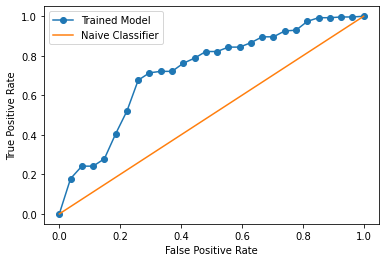

In [19]:
unique_threshes = np.unique(bin_classifier(test_x, w, b))
fp = []
tp = []
total_pos = np.sum(test_y)
for ut in list(unique_threshes) + [-0.1, 1.01]:
    errors = error_types(test_y, bin_classifier(test_x, w, b), ut)
    fp.append(errors[0])               # False positives
    tp.append(total_pos - errors[1])   # True positives = Total - Missed (false negatives)

# sort them so can plot as a line
idx = np.argsort(fp)
fpr = np.array(fp)[idx] / (len(test_y) - np.sum(test_y))
tpr = np.array(tp)[idx] / np.sum(test_y)

# now remove duplicate x-values
fpr_nd = []
tpr_nd = []
last = None
for f, t in zip(fpr, tpr):
    if last is None or f != last:
        last = f
        fpr_nd.append(f)
        tpr_nd.append(t)

plt.plot(fpr_nd, tpr_nd, "-o", label="Trained Model")
plt.plot([0, 1], [0, 1], label="Naive Classifier")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

This plot nicely shows how our trained model is actually sensitive to threshold, so that we could choose to more carefully screen for false negative or false positives. The best curves fall to the top-left of this plot. Our naive classifier is where we return a fixed percentage of examples randomly as positive or negative. You can plot the area under this curve with an integration and this is a good way to measure classifier performance and correctly capture the effect of both false negatives and false positives. The area under the ROC curve is known as the **ROC AUC score** and is preferred to accuracy because it captures the balance of Type I and II errors.

### 4.3. Other Metrics

I will just mention that there are other ways to assess how your model balances the two error types. One major type is called precision and recall. Precision measures correctness of predicted positives and recall measures number of predicted positives. This can be a good viewpoint when doing molecular screening – you may want to be very precise in that your proposed molecules are accurate while sacrificing recall. Recall here meaning you do not return very many molecules. Models on the left of an ROC curve are precise. Models at the top have good recall.

### 4.3.1. Confusion Matrix

A confusion matrix is a table of counts indicating true and predicted classes. For example, consider we are categorizing molecules into three classes: insoluble, weakly soluble, and soluble. We can represent a classifier’s performance in a table:

| True \ Predicted | insoluble | weakly soluble | soluble |
|------------------|-----------|----------------|---------|
| insoluble        |   121     |       8        |     1   |
| weakly soluble   |   7       |       45       |    18   |
| soluble          |   11      |       4        |    56   |

The diagonal elements show when the predicted and true labels agree. For example, 121 molecules were actually insoluble and predicted to be insolbule. We can also read how the classifier failed. One molecule was predicted to be soluble, but was actually insoluble. 4 molecules were predicted to be weakly soluble, but were actually soluble. This can help us understand how the classifier is failing.

## 4.4. Class Imbalance

The reason for this uneven amount of false positives and false negatives is that we have very few negative example – molecules which failed FDA clinical trials. This also explains why just predicting success has a high accuracy. How can we address this problem?

The first answer is do nothing. Is this imbalance a problem at all? Maybe the testing set will see the same class imbalance, meaning that the training set has been properly sampled.

The second solution is to somehow **weight your training data** to appear more like your testing data when you think you do have label shift. There are two ways to accomplish this. You could “augment” your training data by repeating the minority class until the ratio of minority to majority examples matches the assumed testing data. There are research papers written on this topic, with intuitive results. You can **over-sample minority class** but that can lead to a large dataset, so you can also **under-sample the majority class**.

Another method of weighing data is to modify your loss function to increase the gradient updates applied to minority examples. This is equivalent to saying there is a difference in loss between a false positive vs a false negative. In our case, false positives are rarer and more important so we want that when a false positive appears the gradient is significantly affected. We create a weight vector that is high for negative labels so that when they are missclassified (false positive), there will be a bigger update.

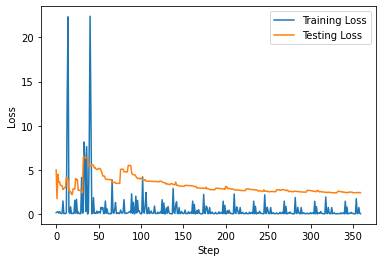

Normal Classifier (20, 19)
Weighted Classifier (8, 115)


In [20]:
def bin_classifier(x, w, b):
    v = jnp.dot(x, w) + b
    y = jax.nn.sigmoid(v)
    return y


def weighted_cross_ent(y, yhat, yw):
    # weights may not be normalized
    N = jnp.sum(yw)
    # use weighted sum instead
    return (
        jnp.sum(
            -(yw * y * jnp.log(yhat + 1e-10) + yw * (1 - y) * jnp.log(1 - yhat + 1e-10))
        )
        / N
    )


def loss_wrapper(w, b, x, y, yw):
    yhat = bin_classifier(x, w, b)
    return weighted_cross_ent(y, yhat, yw)


loss_grad = jax.grad(loss_wrapper, (0, 1))
w2 = np.random.normal(scale=0.01, size=len(features.columns))
b2 = 1.0
weights = np.ones_like(labels)
# make the labels = 0 values be much larger
weights[labels.values == 0] *= 1000
# now make weights be on average 1
# to keep our learning rate/avg update consistent
weights = weights * len(weights) / np.sum(weights)

loss_progress = []
test_loss_progress = []
eta = 0.2
# make epochs larger since this has
# very large steps that converge poorly
for epoch in range(10):
    for i in range(len(batch_idx) - 1):
        x = features[batch_idx[i] : batch_idx[i + 1]].values.astype(np.float32)
        y = labels[batch_idx[i] : batch_idx[i + 1]].values
        yw = weights[batch_idx[i] : batch_idx[i + 1]]
        grad = loss_grad(w2, b2, x, y, yw)
        w2 -= eta * grad[0]
        b2 -= eta * grad[1]
        loss_progress.append(loss_wrapper(w2, b2, x, y, yw))
        test_loss_progress.append(
            loss_wrapper(w2, b2, test_x, test_y, np.ones_like(test_y))
        )
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.legend()
plt.ylabel("Loss")
plt.show()

print("Normal Classifier", error_types(test_y, bin_classifier(test_x, w, b), 0.5))
print("Weighted Classifier", error_types(test_y, bin_classifier(test_x, w2, b2), 0.5))

The spikes in loss occur when we see a rare negative example, which are weighted heavily. Compared to the normal classifier trained above, we have fewer false positives at a threshold of 0.5. However, we also have more false negatives. We saw above that we could tweak this by changing our threshold. Let’s see how our model looks on an ROC curve to compare our model trained with weighting with the previous model at all thresholds.

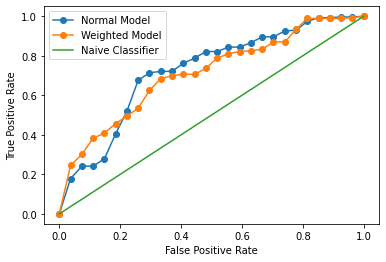

In [21]:
unique_threshes = np.unique(bin_classifier(test_x, w2, b2))
fp = []
tp = []
total_pos = np.sum(test_y)
for ut in list(unique_threshes) + [-0.1, 1.01]:
    errors = error_types(test_y, bin_classifier(test_x, w2, b2), ut)
    fp.append(errors[0])
    tp.append(total_pos - errors[1])

# sort them so can plot as a line
idx = np.argsort(fp)
fpr = np.array(fp)[idx] / (len(test_y) - np.sum(test_y))
tpr = np.array(tp)[idx] / np.sum(test_y)

# now remove duplicate x-values
fpr_nd2 = []
tpr_nd2 = []
last = None
for f, t in zip(fpr, tpr):
    if last is None or f != last:
        last = f
        fpr_nd2.append(f)
        tpr_nd2.append(t)

plt.plot(fpr_nd, tpr_nd, "-o", label="Normal Model")
plt.plot(fpr_nd2, tpr_nd2, "-o", label="Weighted Model")
plt.plot([0, 1], [0, 1], label="Naive Classifier")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

There is improvement in the range 0.05 to 0.2, but then the normal model behaves better.

In summary, we can modify the behavior in the model (to be more precise or have more recall) both in the training process and in the prost training process.

## 4.5. Overfitting

We didn't consider overfitting in this chapter, but we could have used previous techniques la Jacknife+ and cross-validation to assess it, as well as regularization since our model has hundreds of descriptors.

## 4.6. Chapter Summary

- We introduced classification, which is supervised learning with categorical labels. The labels can be single binary values - representing 2 classes which is binary classification.
- We can compute descriptors for molecules using Python packages and do not require them to be part of our dataset
- Cross-entropy loss should be used for classification tasks
- Classification models (called classifiers) can output distance from decision boundary or, more commonly, probability of class
- The Perceptron is an early example of a neural network classifier that has a special training procedure
- The sigmoid and soft-max functions convert real numbers into probabilities
- Binary classification error can be false positives or false negatives
- Accuracy does not distinguish these two errors, so receive-operator characteristic (ROC) curves can be used to assess model performance. Precision and recall are other commonly used measures.
- An imbalance of classes in training data is not necessarily a problem and can be addressed by weighting training examples
